# **Convulotional Neural Networks**

The followings code are inspired from
"Image Preparation for Convolutional Neural Networks with TensorFlow's Keras API" video by deeplizard

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter (action='ignore', category=FutureWarning)
%matplotlib inline

print(np.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1.23.5


In [2]:
# Check for available GPUs and set memory growth for the first GPU

# List all available physical devices (including GPUs)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

# Print the number of available GPUs
print("Num GPUs Available: ", len(physical_devices))

# Set memory growth for the first GPU (assuming at least one GPU is available)
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


# **Data preparation**

In [3]:
# Change the current working directory to '/kaggle/working'
os.chdir('/kaggle/working')

# Define the source directory where the dataset is located
source_directory = '/kaggle/input/catdog-dataset/dogs-and-cats'

# Check if a directory named 'dogcat_dataset' does not exist
if os.path.isdir('dogcat_dataset') is False:
    # If 'dogcat_dataset' does not exist, copy the contents of 'source_directory' to 'dogcat_dataset'
    shutil.copytree(source_directory, 'dogcat_dataset')


In [4]:
# Define paths for training, validation, and test sets
train_path = '/kaggle/working/dogcat_dataset/train'
valid_path = '/kaggle/working/dogcat_dataset/valid'
test_path = '/kaggle/working/dogcat_dataset/test'

# Check if the directories exist and print the results
print(os.path.isdir(train_path))  # Check if 'train' directory exists
print(os.path.isdir(valid_path))  # Check if 'valid' directory exists
print(os.path.isdir(test_path))   # Check if 'test' directory exists


True
True
True


In [5]:
# Define ImageDataGenerator and generate batches of images

# Training set
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

# Validation set
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

# Test set
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)


Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
# Assertions to validate properties of the generated batches

# Ensure that there are 2000 images in the training set
assert train_batches.n == 2000

# Ensure that there are 400 images in the validation set
assert valid_batches.n == 400

# Ensure that there are 200 images in the test set
assert test_batches.n == 200

# Ensure that the number of classes is 2 for all sets (cat and dog)
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2


In [7]:
# Generate a batch of images and their corresponding labels

# Use the 'next' method to get the next batch of images and labels from the training set
imgs, labels = next(train_batches)


In [8]:
# Define a function to plot a series of images

def plotImages(images_arr):
    # Create a figure with 10 subplots arranged in 1 row and 10 columns
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    
    # Flatten the array of axes to make it easier to iterate over
    axes = axes.flatten()
    
    # Iterate through the images and corresponding axes
    for img, ax in zip(images_arr, axes):
        # Display the image on the current axis
        ax.imshow(img)
        
        # Turn off axis labels for better visualization
        ax.axis('off')
    
    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    
    # Display the figure with the images
    plt.show()


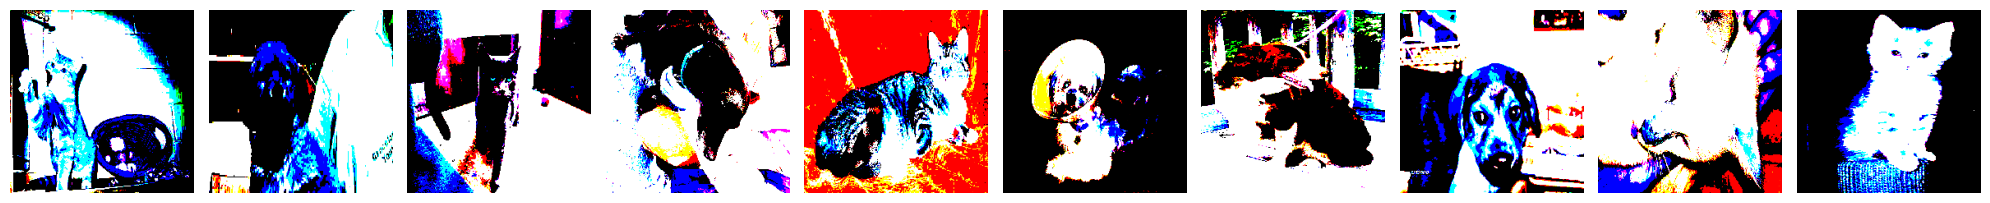

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [9]:
# Plot the images in 'imgs' and print the corresponding labels

# Call the previously defined function 'plotImages' to display the images
plotImages(imgs)

# Print the labels corresponding to the displayed images
print(labels)


# **Build and Train a CNN**

The following codes are inspired from "Build and Train a Convolutional Neural Network with TensorFlow's Keras API" video by deeplizard

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import matplotlib.pyplot as plt

In [11]:
# Define a Sequential model
model = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    
    # Max pooling layer to reduce spatial dimensions
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    # Second convolutional layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    
    # Max pooling layer to further reduce spatial dimensions
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    # Flatten layer to convert 2D feature maps into 1D vector
    Flatten(),
    
    # Fully connected dense layer with 2 units and softmax activation for classification
    Dense(units=2, activation='softmax')
])


In [12]:
# Display a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
200/200 - 14s - loss: 27.3926 - accuracy: 0.5470 - val_loss: 12.8972 - val_accuracy: 0.6900 - 14s/epoch - 68ms/step
Epoch 2/10
200/200 - 5s - loss: 9.0187 - accuracy: 0.7255 - val_loss: 3.1897 - val_accuracy: 0.8575 - 5s/epoch - 27ms/step
Epoch 3/10
200/200 - 5s - loss: 5.1801 - accuracy: 0.8075 - val_loss: 1.7959 - val_accuracy: 0.8925 - 5s/epoch - 27ms/step
Epoch 4/10
200/200 - 5s - loss: 2.8616 - accuracy: 0.8590 - val_loss: 1.0101 - val_accuracy: 0.9175 - 5s/epoch - 27ms/step
Epoch 5/10
200/200 - 6s - loss: 1.3954 - accuracy: 0.9125 - val_loss: 2.3460 - val_accuracy: 0.8650 - 6s/epoch - 28ms/step
Epoch 6/10
200/200 - 5s - loss: 1.6325 - accuracy: 0.9015 - val_loss: 1.0785 - val_accuracy: 0.9375 - 5s/epoch - 27ms/step
Epoch 7/10
200/200 - 5s - loss: 1.2908 - accuracy: 0.9215 - val_loss: 0.4767 - val_accuracy: 0.9600 - 5s/epoch - 27ms/step
Epoch 8/10
200/200 - 5s - loss: 0.9324 - accuracy: 0.9420 - val_loss: 0.1369 - val_accuracy: 0.9850 - 5s/epoch - 27ms/step
Epoch 9/10
2

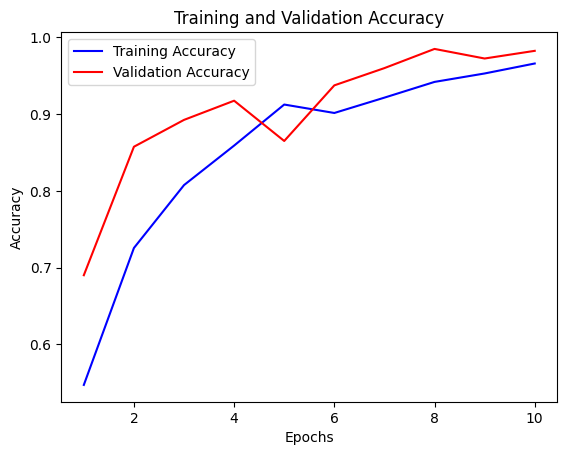

In [15]:
# Retrieve training and validation accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')  # Blue line for training accuracy
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')  # Red line for validation accuracy

# Add title and labels to the plot
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to differentiate between training and validation accuracy
plt.legend()

# Show the plot
plt.show()


# **Predict**

The following codes are inspired from "Convolutional Neural Network Predictions with TensorFlow's Keras API" video by deeplizard

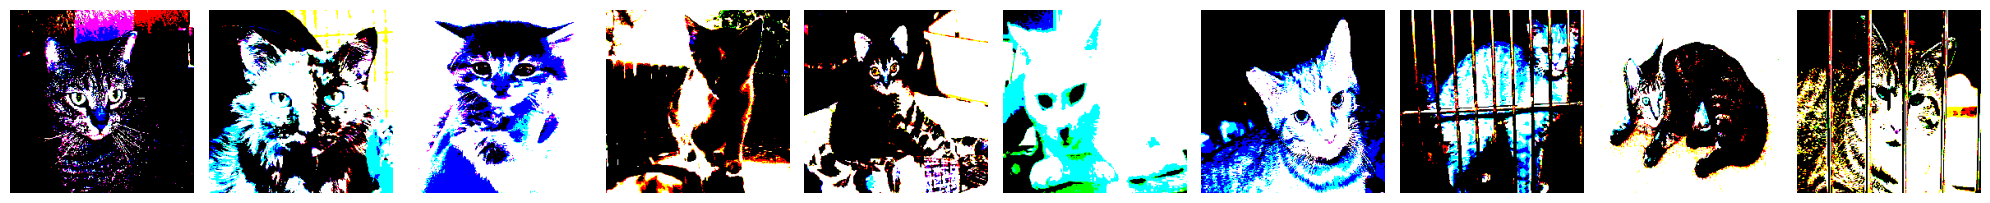

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [16]:
# Generate a batch of test images and their corresponding labels
test_imgs, test_labels = next(test_batches)

# Plot the test images
plotImages(test_imgs)

# Print the labels corresponding to the displayed test images
print(test_labels)


In [17]:
# Get the class labels for the images in the test set
test_classes = test_batches.classes

In [18]:
# Make predictions on the test set
predictions = model.predict(x=test_batches, verbose=0)

In [19]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [20]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [21]:
def plot_confusion_matrix(cm, classes,
                         normalize=False, 
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        # Normalize the confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    # Add text annotations to the cells
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    # Adjust layout for better visualization
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [22]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[97  3]
 [ 2 98]]


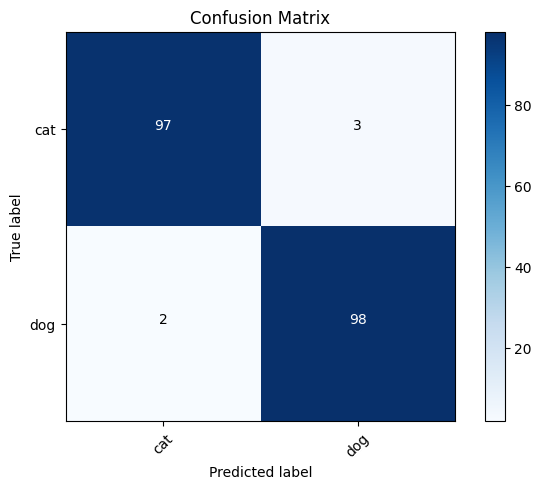

In [23]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [24]:
# The code below prints out all the processed data which takes a really long time that's why I modified the code and only print out the overall test accuracy
# test_accuracy_values = []

# while True:
#     try:
#         test_data_batch, test_labels_batch = next(test_batches)
#         test_loss, test_accuracy = model.evaluate(test_data_batch, test_labels_batch)
#         test_accuracy_values.append(test_accuracy)
#     except StopIteration:
#         break  # Break the loop when you've processed all batches

# # Calculate the overall test accuracy
# overall_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)
# print("Overall Test Accuracy:", overall_test_accuracy)



test_accuracy_values = []
batch_counter = 0

while batch_counter < 50:
    try:
        test_data_batch, test_labels_batch = next(test_batches)
        test_loss, test_accuracy = model.evaluate(test_data_batch, test_labels_batch, verbose=0)
        test_accuracy_values.append(test_accuracy)
        batch_counter += 1
    except StopIteration:
        break
# Calculate the overall test accuracy
overall_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)
print("Overall Test Accuracy:", overall_test_accuracy)


Overall Test Accuracy: 0.9719999933242798


# **Data Augmentation**

The following codes are inspired from "Data Augmentation with TensorFlow's Keras API" video by deeplizard

Data augmentation occurs when you create new data based on modifications be images. Data augmentation on images would include transformations like:
Flipping the image either horizontally or vertically
- Rotating the image
- Zooming in or out on the image
- Cropping the image
- Varying the color on the image

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
%matplotlib inline

In [26]:
# Define a function to plot a series of images

def plotImages(images_arr):
    # Create a figure with 10 subplots arranged in 1 row and 10 columns
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    
    # Flatten the array of axes to make it easier to iterate over
    axes = axes.flatten()
    
    # Iterate through the images and corresponding axes
    for img, ax in zip(images_arr, axes):
        # Display the image on the current axis
        ax.imshow(img)
        
        # Turn off axis labels for better visualization
        ax.axis('off')
    
    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    
    # Display the figure with the images
    plt.show()


In [27]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
       channel_shift_range=10., horizontal_flip=True)

In [28]:
chosen_image = random.choice(os.listdir('/kaggle/working/dogcat_dataset/test/dog'))

In [29]:
image_path = '/kaggle/working/dogcat_dataset/test/dog/' + chosen_image


In [30]:
assert os.path.isfile(image_path)

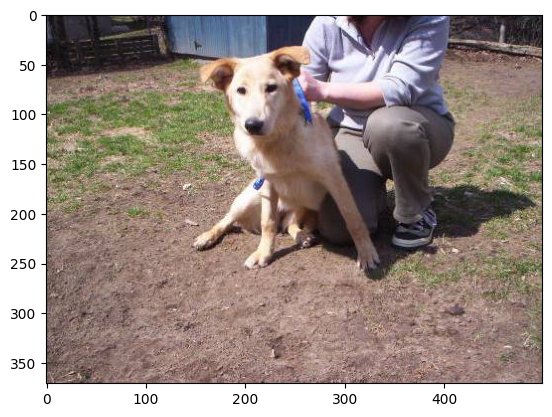

In [31]:
# Obtain image
image =np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [32]:
# Generate batche of augmented images from this image
aug_iter = gen.flow(image)

In [33]:
# Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

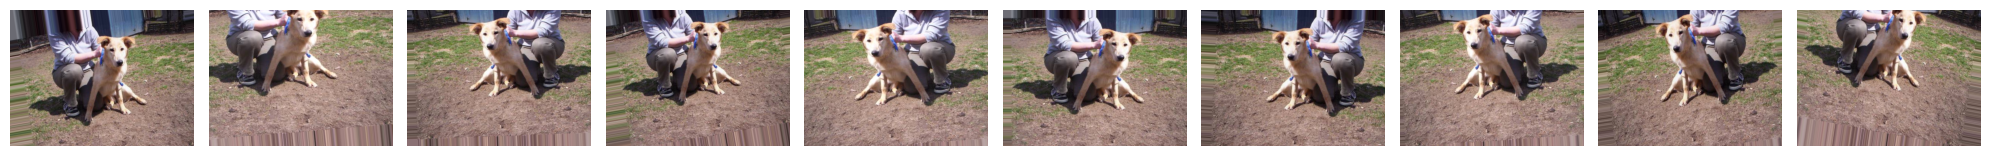

In [34]:
# Augmented images
plotImages(aug_images)

# **Build a Fine-Tuned VGG16 model**

The following codes are inspired from "Build a Fine-Tuned Neural Network with TensorFlow's Keras API" video by deeplizard

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [36]:
# Download model - Internet connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 20s 0us/step


In [37]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [39]:
params = count_params(vgg16_model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 138357544

In [40]:
type(vgg16_model)

keras.engine.functional.Functional

In [41]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [43]:
for layer in model.layers:
    layer.trainable = False

In [44]:
model.add(Dense(units=2, activation='softmax'))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

# **Train the Fine-Tuned VGG16 model**

The following codes are inspired from "Train a Fine-Tuned Neural Network with TensorFlow's Keras API" video by deeplizard

In [46]:
# Prepares the model for training

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
200/200 - 9s - loss: 1.6493 - accuracy: 0.5145 - val_loss: 1.8242 - val_accuracy: 0.4950 - 9s/epoch - 47ms/step
Epoch 2/5
200/200 - 8s - loss: 1.0837 - accuracy: 0.5145 - val_loss: 0.8870 - val_accuracy: 0.5025 - 8s/epoch - 38ms/step
Epoch 3/5
200/200 - 7s - loss: 0.7116 - accuracy: 0.5130 - val_loss: 0.7020 - val_accuracy: 0.5050 - 7s/epoch - 37ms/step
Epoch 4/5
200/200 - 8s - loss: 0.7195 - accuracy: 0.5105 - val_loss: 0.7081 - val_accuracy: 0.5025 - 8s/epoch - 39ms/step
Epoch 5/5
200/200 - 7s - loss: 0.7034 - accuracy: 0.5130 - val_loss: 0.7277 - val_accuracy: 0.4950 - 7s/epoch - 37ms/step


In [48]:
# assert model.history.history.get('accuracy')[-1] > 0.95